In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_pickle('ResAss_w_PbSch_Rtngs_Clnd_df.p')

In [4]:
df['Zipcode'] = df['ZipCode_reduced'].astype(int)
df.drop('ZipCode_reduced', axis=1, inplace=True)

In [5]:
df['Documentation_YearAge'] = 2017.0 - df['DocumentDate'].dt.year
df['Documentation_month'] = df['DocumentDate'].dt.month

df.drop(['DocumentDate'], axis=1, inplace=True)

In [6]:
df['TotalCost'] = df['SalePrice'] + df['AddnlCost']

In [7]:
len(df)

71417

In [8]:
def SaleWarning_conv(df):
    df.SaleWarning = df.SaleWarning.apply(lambda x: x.split())
    warningdummies = pd.get_dummies(df.SaleWarning.apply(pd.Series).stack(), prefix='SWarn', drop_first=False).sum(level=0)
    df = df.join(warningdummies, how='left').fillna(0.0)
    df = df.drop('SaleWarning', axis=1)
    return df

In [9]:
df = SaleWarning_conv(df)

In [10]:
def Zipcode_converter(df):
    Zipcode_dummies = pd.get_dummies(df.Zipcode, drop_first=False)
    df = pd.concat([df, Zipcode_dummies], axis=1).drop('Zipcode', axis=1)
    return df

In [11]:
df = Zipcode_converter(df)

In [12]:
def HeatSource_converter(df):
    HeatSource_dummies = pd.get_dummies(df.HeatSource, drop_first=False, prefix='HeatSource')
    df = pd.concat([df, HeatSource_dummies], axis=1).drop('HeatSource', axis=1)
    return df

In [13]:
def HeatSystem_converter(df):
    HeatSystem_dummies = pd.get_dummies(df.HeatSystem, drop_first=False, prefix='HeatSystem')
    df = pd.concat([df, HeatSystem_dummies], axis=1).drop('HeatSystem', axis=1)
    return df

In [14]:
def SqFTLiving_check(df):
    df = df[df.SqFtTotLiving > 500]
    return df

In [15]:
def NumLivingUnits_check(df):
    df = df[df.NbrLivingUnits <= 2]
    return df

In [16]:
df = HeatSource_converter(df)

In [17]:
df = HeatSystem_converter(df)

In [18]:
df = SqFTLiving_check(df)

In [19]:
df = NumLivingUnits_check(df)

In [20]:
df.drop(['Address', 'StreetName', 'StreetType', 'SellerName', 'BuyerName', 'DirectionSuffix', 
         'parcel_number', 'PROP_NAME', 'ES_ZONE', 'MS_ZONE', 'HS_ZONE', 'LEVY_JURIS', 'SalePrice', 
         'AddnlCost', 'ExciseTaxNbr', 'BldgGrade', 'SaleReason', 'SaleInstrument', 'FinBasementGrade'], axis=1, inplace=True)

In [21]:
uplimit = min(df.TotalCost.mean() + df.TotalCost.std()*4, 2000000)
bottomlimit = 100000 # min(abs(df.TotalCost.mean() - df.TotalCost.std()*4), df.TotalCost.min())
print uplimit, bottomlimit

1744229.65165 100000


In [22]:
df = df[(df.TotalCost > bottomlimit) & (df.TotalCost < uplimit)]

In [23]:
df.TotalCost.max(), df.TotalCost.min(), len(df)

(1740000, 100001, 63142)

In [24]:
df.TotalCost.describe()

count    6.314200e+04
mean     3.846499e+05
std      2.521398e+05
min      1.000010e+05
25%      2.000000e+05
50%      3.230000e+05
75%      4.850000e+05
max      1.740000e+06
Name: TotalCost, dtype: float64

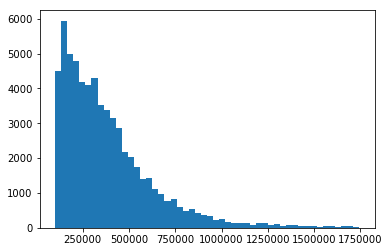

In [25]:
plt.hist(df.TotalCost, bins=50, range=(bottomlimit, uplimit));

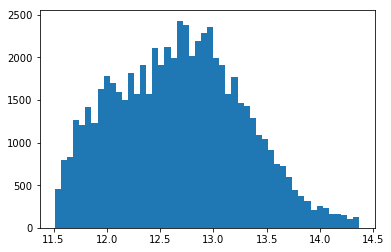

In [26]:
plt.hist(np.log(df.TotalCost), bins=50);

In [27]:
y = df.TotalCost
X = df.drop('TotalCost', axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [29]:
FSM1 = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=0)
FSM1.fit(X_train, y_train)
y_predict1 = FSM1.predict(X_test).astype(int)
y_true = y_test.as_matrix()
FSM1.score(X_test, y_test)

0.78665004863030219

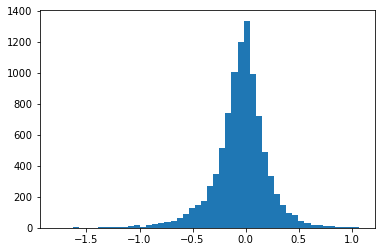

In [30]:
residuals = np.log(y_true) - np.log(y_predict1)
plt.hist(residuals, bins=50);

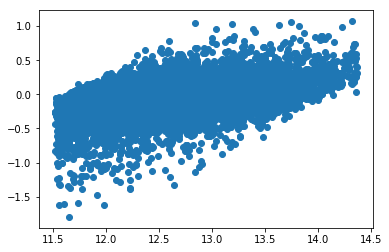

In [31]:
plt.scatter(np.log(y_true), residuals);

In [32]:
# mean_absolute_error(y_true, y_predict1)

In [33]:
median_absolute_error(y_true, y_predict1)

38793.5

In [34]:
y.mean(), y.max(), y.min()

(384649.88912292925, 1740000, 100001)

In [35]:
# np.sqrt(mean_squared_error(y_true, y_predict1))

In [36]:
# y_log = np.log(df1.TotalCost)
# X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.15, random_state=42)

In [37]:
# FSM2 = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=0)
# FSM2.fit(X_train_log, y_train_log)
# y_predict2 = FSM2.predict(X_test_log).astype(int)
# y_true_log = y_test_log.as_matrix()
# FSM2.score(X_test_log, y_test_log)

In [38]:
# residuals2 = y_true_log - y_predict2
# plt.hist(residuals2, bins=50);

In [39]:
# median_absolute_error(y_true_log, y_predict2), np.exp(median_absolute_error(y_true_log, y_predict2))

In [40]:
print sum(abs(residuals))/len(y_predict1) # --> Winner is RF with subsected price range
# print sum(abs(residuals2))/len(y_predict2)
# print sum(abs(residuals3))/len(y_predict3)
# print sum((residuals4))/len(y_predict4)
print abs(1 - np.exp(sum(abs(residuals))/len(y_predict1)))*100

0.179850100289
19.7037914035


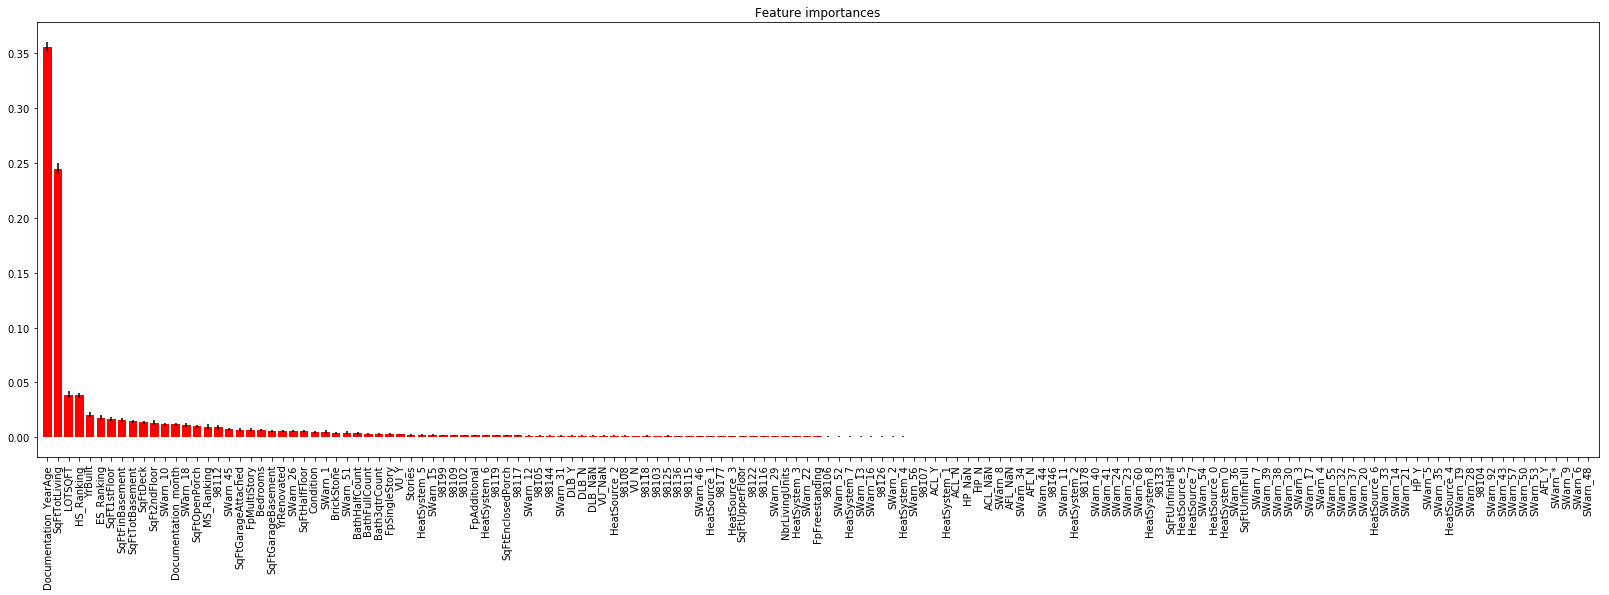

In [41]:
importances = FSM1.feature_importances_
std = np.std([tree.feature_importances_ for tree in FSM1.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(28,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show();

In [42]:
def new_prediction_matrix(df):
    df['Documentation_YearAge'] = 0
    return df

In [43]:
X_predict = new_prediction_matrix(X)

In [44]:
X_predict.head()

,NbrLivingUnits,Stories,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,DLB_N,DLB_NaN,DLB_Y,HP_N,HP_NaN,HP_Y,AFL_N,AFL_NaN,AFL_Y,ACL_N,ACL_NaN,ACL_Y,VU_N,VU_NaN,VU_Y,LOTSQFT,ES_Ranking,MS_Ranking,HS_Ranking,Documentation_YearAge,Documentation_month,SWarn_*,SWarn_1,SWarn_10,SWarn_11,SWarn_12,SWarn_13,SWarn_14,SWarn_15,SWarn_16,SWarn_17,SWarn_18,SWarn_19,SWarn_2,SWarn_20,SWarn_21,SWarn_22,SWarn_23,SWarn_24,SWarn_26,SWarn_28,SWarn_29,SWarn_3,SWarn_30,SWarn_31,SWarn_32,SWarn_33,SWarn_34,SWarn_35,SWarn_36,SWarn_37,SWarn_38,SWarn_39,SWarn_4,SWarn_40,SWarn_41,SWarn_43,SWarn_44,SWarn_45,SWarn_46,SWarn_48,SWarn_5,SWarn_50,SWarn_51,SWarn_52,SWarn_53,SWarn_54,SWarn_55,SWarn_56,SWarn_57,SWarn_6,SWarn_60,SWarn_7,SWarn_8,SWarn_9,SWarn_92,98102,98103,98104,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98177,98178,98199,HeatSource_0,HeatSource_1,HeatSource_2,HeatSource_3,HeatSource_4,HeatSource_5,HeatSource_6,HeatSource_7,HeatSystem_0,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,HeatSystem_8
0,1,1.0,1030,0,0,0,0,0,1230,920,200,240,0,0,0,240,0,4,0,1,2,0,0,0,0,1977,0,3,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,6000.0,4,8,5,0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1.0,1030,0,0,0,0,0,1230,920,200,240,0,0,0,240,0,4,0,1,2,0,0,0,0,1977,0,3,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,6000.0,4,8,5,0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,1.0,1350,0,0,0,0,0,1350,430,0,0,0,50,0,0,0,4,0,0,1,1,0,0,0,1900,0,3,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,6000.0,4,8,5,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,2.0,1080,0,1080,0,0,0,2700,1080,540,0,0,0,0,750,0,4,0,2,1,0,1,0,1,1954,0,4,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,6050.0,4,8,5,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,2.0,1080,0,1080,0,0,0,2700,1080,540,0,0,0,0,750,0,4,0,2,1,0,1,0,1,1954,0,4,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,6050.0,4,8,5,0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [45]:
y_predict = FSM1.predict(X_predict).astype(int)

In [55]:
dir()

['FSM1',
 'GradientBoostingRegressor',
 'GridSearchCV',
 'HeatSource_converter',
 'HeatSystem_converter',
 'In',
 'LinearRegression',
 'NumLivingUnits_check',
 'Out',
 'Pipeline',
 'RandomForestRegressor',
 'SaleWarning_conv',
 'SqFTLiving_check',
 'X',
 'X_predict',
 'X_test',
 'X_train',
 'Zipcode_converter',
 '_',
 '_23',
 '_24',
 '_29',
 '_33',
 '_34',
 '_44',
 '_7',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__name__',
 '__package__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i43',
 '_i44',
 '_i45',
 '_i46',
 '_i47',
 '_i48',
 '_i49',
 '_i5',
 '_i50',
 '_i51',
 '_i52',
 '_i53',
 '_i54',
 '_i55',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 '_

In [56]:
del(GradientBoostingRegressor)
del(GridSearchCV)
del(HeatSource_converter)
del(HeatSystem_converter)
del(LinearRegression)
del(NumLivingUnits_check)
del(Pipeline)
del(SaleWarning_conv)
del(SqFTLiving_check)
del(Zipcode_converter)
del(X_train)
del(X_test)
del(df)

In [59]:
y_predict

array([641486, 610164, 686505, ..., 795411, 805345, 997161])

In [60]:
Matrix = X_predict

In [61]:
Matrix['TotalCost'] = y_predict

In [63]:
Matrix.head(20)

,NbrLivingUnits,Stories,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,DLB_N,DLB_NaN,DLB_Y,HP_N,HP_NaN,HP_Y,AFL_N,AFL_NaN,AFL_Y,ACL_N,ACL_NaN,ACL_Y,VU_N,VU_NaN,VU_Y,LOTSQFT,ES_Ranking,MS_Ranking,HS_Ranking,Documentation_YearAge,Documentation_month,SWarn_*,SWarn_1,SWarn_10,SWarn_11,SWarn_12,SWarn_13,SWarn_14,SWarn_15,SWarn_16,SWarn_17,SWarn_18,SWarn_19,SWarn_2,SWarn_20,SWarn_21,SWarn_22,SWarn_23,SWarn_24,SWarn_26,SWarn_28,SWarn_29,SWarn_3,SWarn_30,SWarn_31,SWarn_32,SWarn_33,SWarn_34,SWarn_35,SWarn_36,SWarn_37,SWarn_38,SWarn_39,SWarn_4,SWarn_40,SWarn_41,SWarn_43,SWarn_44,SWarn_45,SWarn_46,SWarn_48,SWarn_5,SWarn_50,SWarn_51,SWarn_52,SWarn_53,SWarn_54,SWarn_55,SWarn_56,SWarn_57,SWarn_6,SWarn_60,SWarn_7,SWarn_8,SWarn_9,SWarn_92,98102,98103,98104,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98177,98178,98199,HeatSource_0,HeatSource_1,HeatSource_2,HeatSource_3,HeatSource_4,HeatSource_5,HeatSource_6,HeatSource_7,HeatSystem_0,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,HeatSystem_8,TotalCost
0,1,1.0,1030,0,0,0,0,0,1230,920,200,240,0,0,0,240,0,4,0,1,2,0,0,0,0,1977,0,3,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,6000.0,4,8,5,0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,641486
1,1,1.0,1030,0,0,0,0,0,1230,920,200,240,0,0,0,240,0,4,0,1,2,0,0,0,0,1977,0,3,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,6000.0,4,8,5,0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,610164
2,1,1.0,1350,0,0,0,0,0,1350,430,0,0,0,50,0,0,0,4,0,0,1,1,0,0,0,1900,0,3,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,6000.0,4,8,5,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,686505
3,1,2.0,1080,0,1080,0,0,0,2700,1080,540,0,0,0,0,750,0,4,0,2,1,0,1,0,1,1954,0,4,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,6050.0,4,8,5,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1164949
4,1,2.0,1080,0,1080,0,0,0,2700,1080,540,0,0,0,0,750,0,4,0,2,1,0,1,0,1,1954,0,4,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,6050.0,4,8,5,0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1145697
5,1,2.0,1080,0,1080,0,0,0,2700,1080,540,0,0,0,0,750,0,4,0,2,1,0,1,0,1,1954,0,4,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,6050.0,4,8,5,0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

In [65]:
SqFtLiving = 700
Bedrooms = 1

In [70]:
Matrix_subset = Matrix[(Matrix.SqFtTotLiving > SqFtLiving*0.90) & (Matrix.SqFtTotLiving < SqFtLiving*1.1) & (Matrix.Bedrooms <= (Bedrooms+1)) & (Matrix.Bedrooms >= (Bedrooms+1))]

In [71]:
len(Matrix_subset)

1039

In [79]:
Matrix_subset.head()

,NbrLivingUnits,Stories,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,DLB_N,DLB_NaN,DLB_Y,HP_N,HP_NaN,HP_Y,AFL_N,AFL_NaN,AFL_Y,ACL_N,ACL_NaN,ACL_Y,VU_N,VU_NaN,VU_Y,LOTSQFT,ES_Ranking,MS_Ranking,HS_Ranking,Documentation_YearAge,Documentation_month,SWarn_*,SWarn_1,SWarn_10,SWarn_11,SWarn_12,SWarn_13,SWarn_14,SWarn_15,SWarn_16,SWarn_17,SWarn_18,SWarn_19,SWarn_2,SWarn_20,SWarn_21,SWarn_22,SWarn_23,SWarn_24,SWarn_26,SWarn_28,SWarn_29,SWarn_3,SWarn_30,SWarn_31,SWarn_32,SWarn_33,SWarn_34,SWarn_35,SWarn_36,SWarn_37,SWarn_38,SWarn_39,SWarn_4,SWarn_40,SWarn_41,SWarn_43,SWarn_44,SWarn_45,SWarn_46,SWarn_48,SWarn_5,SWarn_50,SWarn_51,SWarn_52,SWarn_53,SWarn_54,SWarn_55,SWarn_56,SWarn_57,SWarn_6,SWarn_60,SWarn_7,SWarn_8,SWarn_9,SWarn_92,98102,98103,98104,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98177,98178,98199,HeatSource_0,HeatSource_1,HeatSource_2,HeatSource_3,HeatSource_4,HeatSource_5,HeatSource_6,HeatSource_7,HeatSystem_0,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,HeatSystem_8,TotalCost
15,1,1.0,710,0,0,0,0,0,710,0,0,0,0,220,0,0,0,2,0,0,1,0,0,1,0,1942,0,3,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,9120.0,6,7,6,0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,406892
17,1,1.0,710,0,0,0,0,0,710,0,0,0,0,220,0,0,0,2,0,0,1,0,0,1,0,1942,0,3,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,9120.0,6,7,6,0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,407954
243,1,1.0,660,0,0,0,0,0,660,230,0,0,0,0,0,100,0,2,0,0,1,0,0,0,0,1905,0,3,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,3465.0,10,10,10,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,616647
245,1,1.0,660,0,0,0,0,0,660,230,0,0,0,0,0,100,0,2,0,0,1,0,0,0,0,1905,0,3,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,3465.0,10,10,10,0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,653634
330,1,1.0,730,0,0,0,0,0,730,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,1929,0,3,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,4440.0,10,9,10,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,543239


In [90]:
Matrix_subset[98117]

15       0
17       0
243      1
245      1
330      1
331      1
332      1
413      0
512      1
513      1
572      1
573      1
612      0
1032     0
1033     0
1034     0
1417     0
1418     0
1419     0
1420     0
1616     1
1774     1
1844     0
2230     0
2333     0
2334     0
2335     0
2336     0
2486     0
2487     0
        ..
70066    0
70179    0
70181    0
70182    0
70240    0
70241    0
70242    0
70326    0
70327    0
70353    0
70463    0
70594    0
70595    0
70634    0
70635    0
70636    0
70637    0
70638    0
70639    0
70646    0
70964    0
70965    0
71136    0
71137    0
71138    0
71139    0
71140    0
71205    0
71237    0
71238    0
Name: 98117, Length: 1039, dtype: uint8

In [92]:
Matrix_98102 = Matrix_subset[Matrix_subset[98102]==1]
Matrix_98103 = Matrix_subset[Matrix_subset[98103]==1]
Matrix_98104 = Matrix_subset[Matrix_subset[98104]==1]
Matrix_98105 = Matrix_subset[Matrix_subset[98105]==1]
Matrix_98106 = Matrix_subset[Matrix_subset[98106]==1]
Matrix_98107 = Matrix_subset[Matrix_subset[98107]==1]
Matrix_98108 = Matrix_subset[Matrix_subset[98108]==1]
Matrix_98109 = Matrix_subset[Matrix_subset[98109]==1]
Matrix_98112 = Matrix_subset[Matrix_subset[98112]==1]
Matrix_98115 = Matrix_subset[Matrix_subset[98115]==1]
Matrix_98116 = Matrix_subset[Matrix_subset[98116]==1]
Matrix_98117 = Matrix_subset[Matrix_subset[98117]==1]
Matrix_98118 = Matrix_subset[Matrix_subset[98118]==1]
Matrix_98119 = Matrix_subset[Matrix_subset[98119]==1]
Matrix_98122 = Matrix_subset[Matrix_subset[98122]==1]
Matrix_98125 = Matrix_subset[Matrix_subset[98125]==1]
Matrix_98126 = Matrix_subset[Matrix_subset[98126]==1]
Matrix_98133 = Matrix_subset[Matrix_subset[98133]==1]
Matrix_98136 = Matrix_subset[Matrix_subset[98136]==1]
Matrix_98144 = Matrix_subset[Matrix_subset[98144]==1]
Matrix_98146 = Matrix_subset[Matrix_subset[98146]==1]
Matrix_98177 = Matrix_subset[Matrix_subset[98177]==1]
Matrix_98178 = Matrix_subset[Matrix_subset[98178]==1]
Matrix_98199 = Matrix_subset[Matrix_subset[98199]==1]

In [93]:
zipcode_lst = [Matrix_98102, Matrix_98103, Matrix_98104, Matrix_98105, Matrix_98106, Matrix_98107, Matrix_98108, Matrix_98109, Matrix_98112, Matrix_98115, Matrix_98116, Matrix_98117,
               Matrix_98118, Matrix_98119, Matrix_98122, Matrix_98125, Matrix_98126, Matrix_98133, Matrix_98136, Matrix_98144, Matrix_98146, Matrix_98177, Matrix_98178, Matrix_98199]

In [98]:
Seattle_Zipcodes = [98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 98122, 98125, 98126, 98133, 98136, 
                    98144, 98146, 98177, 98178, 98199]

In [ ]:
number_of_kids = 2
age_of_kids = [6, 8]


In [117]:
for code, matrix in zip(Seattle_Zipcodes, zipcode_lst):
    if len(matrix)!=0:
        print code, '\t', len(matrix), '\t', matrix.TotalCost.mean() - matrix.TotalCost.std()*1.96, '\t', '<',matrix.TotalCost.mean(), '\t', '<', matrix.TotalCost.mean() + matrix.TotalCost.std()*1.96, '\t', matrix.ES_Ranking.median(), '\t', matrix.MS_Ranking.median(), '\t', matrix.HS_Ranking.median()

98102 	8 	446779.166229 	< 538084.0 	< 629388.833771 	10.0 	8.0 	5.0
98103 	65 	429273.199107 	< 556281.892308 	< 683290.585509 	9.0 	9.0 	9.0
98105 	23 	573430.467362 	< 627233.0 	< 681035.532638 	9.0 	10.0 	10.0
98106 	120 	275481.790362 	< 437226.033333 	< 598970.276305 	2.0 	7.0 	6.0
98107 	35 	535742.976834 	< 609375.371429 	< 683007.766024 	10.0 	10.0 	10.0
98108 	61 	180706.910449 	< 460237.491803 	< 739768.073158 	3.0 	7.0 	6.0
98109 	4 	440421.040542 	< 598794.0 	< 757166.959458 	10.0 	9.0 	10.0
98112 	10 	552818.910896 	< 597383.5 	< 641948.089104 	9.0 	8.0 	5.0
98115 	84 	415714.893757 	< 535008.190476 	< 654301.487195 	9.0 	9.0 	9.0
98116 	29 	361311.974954 	< 601478.551724 	< 841645.128494 	10.0 	9.0 	5.0
98117 	108 	468870.793321 	< 575608.055556 	< 682345.31779 	10.0 	9.0 	10.0
98118 	81 	232024.221046 	< 489917.901235 	< 747811.581423 	5.0 	9.0 	8.0
98119 	26 	508609.205802 	< 598615.076923 	< 688620.948044 	10.0 	9.0 	10.0
98122 	40 	322658.412743 	< 515503.125 	< 7083

In [89]:
Matrix_subset.columns.values

array(['NbrLivingUnits', 'Stories', 'SqFt1stFloor', 'SqFtHalfFloor',
       'SqFt2ndFloor', 'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf',
       'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'SqFtGarageBasement', 'SqFtGarageAttached', 'SqFtOpenPorch',
       'SqFtEnclosedPorch', 'SqFtDeck', 'BrickStone', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'FpSingleStory',
       'FpMultiStory', 'FpFreestanding', 'FpAdditional', 'YrBuilt',
       'YrRenovated', 'Condition', 'DLB_N', 'DLB_NaN', 'DLB_Y', 'HP_N',
       'HP_NaN', 'HP_Y', 'AFL_N', 'AFL_NaN', 'AFL_Y', 'ACL_N', 'ACL_NaN',
       'ACL_Y', 'VU_N', 'VU_NaN', 'VU_Y', 'LOTSQFT', 'ES_Ranking',
       'MS_Ranking', 'HS_Ranking', 'Documentation_YearAge',
       'Documentation_month', 'SWarn_*', 'SWarn_1', 'SWarn_10', 'SWarn_11',
       'SWarn_12', 'SWarn_13', 'SWarn_14', 'SWarn_15', 'SWarn_16',
       'SWarn_17', 'SWarn_18', 'SWarn_19', 'SWarn_2', 'SWarn_20',
       'SWarn_21', 'SWarn_22', 'SWa

In [ ]:
#FSM3 = GradientBoostingRegressor()
#FSM3.fit(X_train, y_train)
#y_predict3 = FSM3.predict(X_test).astype(int)
#FSM3.score(X_test, y_test)

In [47]:
#residuals3 = np.log(y_true) - np.log(y_predict3)
#plt.hist(residuals3, bins=50);

In [48]:
#FSM4 = GradientBoostingRegressor()
#FSM4.fit(X_train_log, y_train_log)
#y_predict4 = FSM4.predict(X_test_log).astype(int)
#FSM4.score(X_test_log, y_test_log)

In [49]:
#residuals4 = y_true_log - y_predict4
#plt.hist(residuals4, bins=50);

In [50]:
#FSM5 = GradientBoostingRegressor(learning_rate=0.1)
#FSM5.fit(X_train, y_train)
#y_predict5 = FSM5.predict(X_test).astype(int)
#print FSM5.score(X_test, y_test)
#residuals5 = np.log(y_true) - np.log(y_predict5)
#print sum(abs(residuals5))/len(y_predict5)

In [51]:
#plt.hist(residuals5, bins=50);

In [52]:
#importances5 = FSM5.feature_importances_
#std5 = np.std([tree.feature_importances_ for tree in FSM5.estimators_],
#            axis=0)
#indices5 = np.argsort(importances5)[::-1]

#plt.figure(figsize=(20,8))
#plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances5[indices5],
#       color="r", yerr=std5[indices5], align="center")
#plt.xticks(range(X.shape[1]), X.columns[indices5],rotation='vertical')
#plt.xlim([-1, X.shape[1]])
#plt.show();

In [53]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline

In [54]:
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}